<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit8/YaleXie_Unit8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project

## Part I: Introduction

For my Unit 8 project, I will use BART to create a model that relates five finance factors to predict Walmart's yearly stock price change. Those five factors are MKT, SMB, HML, RMW, and CMA. I want to see if these five factors are equally important to the analysis of Walmart's historical stock price change and if they are more correlated with each other than we previously thought.

**Extra info for finance nerds:**

The five factors I just mentioned (MKT, SMB, HML, RMW, CMA) are actually previously defined factors for stock returns from Eugene Fama and Kenneth French's groundbreaking finance paper *Common Risk Factors in the Returns of Stocks and Bonds* (1992) and their follow-up paper *A five-factor asset pricing model* (2014). These papers introduced four additional factors to the original Capital Asset Pricing Model (CAPM), which only had one factor: **MKT**, or the excess return of a general market portfolio over the risk-free rate.

**SMB** stands for "Small Minus Big" and it describes the excess returns of small-cap stocks over large-cap stocks. **HML** stands for "High Minus Low" and it describes the excess returns of high book-to-market equity ratio stocks to low book-to-market equity ratio stocks. **RMW** stands for "Robust Minus Weak" and it describes the excess return of robust operating profitability stocks over weak operating profitability stocks. Finally, **CMA** stands for "Conservative Minus Aggressive" and it describes the excess returns of conservative investment stocks over aggressive investment stocks.

Together, these five factors account for approximately 90-95% of a stock's expected returns. The Fama-French Five-Factor Model is a robust way of checking portfolios are being well managed: a significant positive alpha (returns unexplained by the five factors) may indicate that the portfolio manager is performing exceptionally well.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [ ]:
!pip install pymc-bart

In [ ]:
import pymc_bart as pmb

## Part II: Data

The data I am using comes from Kenneth French's website and the MacroTrends website. Let's upload the data by reading the csv file I created by combining the data from the two websites.

In [ ]:
ff_stats = pd.read_csv("https://raw.githubusercontent.com/xeqoir/Data-Science/refs/heads/main/Unit7/Unit%207%20Data%20-%20Sheet1.csv").dropna()
ff_stats.head(5)

,Year,MKT,SMB,HML,RMW,CMA,Change
0,1973,-26.18,-23.51,17.47,-8.76,7.18,-61.48
1,1974,-35.75,-0.81,9.96,-4.43,22.74,-28.85
2,1975,32.44,15.41,9.14,0.92,0.40,178.38
3,1976,21.91,14.67,24.38,-6.53,7.42,17.48
4,1977,-8.26,22.62,7.46,2.43,-0.01,30.58


In [ ]:
X = ff_stats[["MKT", "SMB", "HML", "RMW", "CMA"]]
Y = ff_stats["Change"].to_numpy()

In [ ]:
print(ff_stats.MKT.mean())
print(ff_stats.SMB.mean())
print(ff_stats.HML.mean())
print(ff_stats.RMW.mean())
print(ff_stats.CMA.mean())
print(ff_stats.Change.mean())

8.113673469387756
2.1204081632653056
3.7361224489795917
3.7751020408163267
3.743469387755102
24.63693877551021


**Short finance aside:**

The fact that all five factors are positive on average indicates that Fama and French's factors are working as expected. Each of these factors are the excess return of a portfolio of a certain type over a weaker alternative (supposedly). These excess returns should be positive, which is what we have observed here. We also see that the average change in stock price for Walmart over the past half century has been 24.64% per year.

## Part III: Causal Diagram

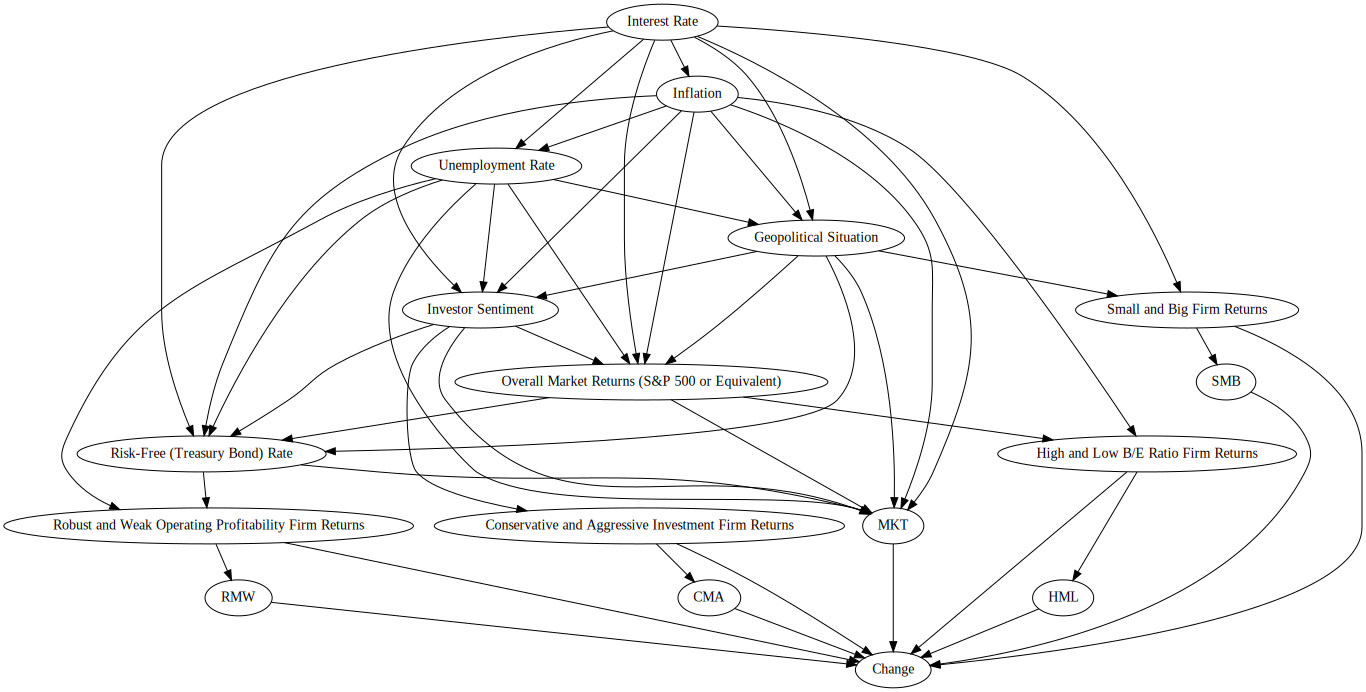

In [ ]:
import graphviz as gr

dot = gr.Digraph(format = 'png')

dot.node("Change") # change
dot.node("MKT") # 5 factors
dot.node("SMB")
dot.node("HML")
dot.node("RMW")
dot.node("CMA")
dot.node("intr", "Interest Rate")
dot.node("infl", "Inflation")
dot.node("empl", "Unemployment Rate")
dot.node("invs", "Investor Sentiment")
dot.node("geop", "Geopolitical Situation")
dot.node("mkt", "Overall Market Returns (S&P 500 or Equivalent)")
dot.node("tre", "Risk-Free (Treasury Bond) Rate")
dot.node("smb", "Small and Big Firm Returns")
dot.node("hml", "High and Low B/E Ratio Firm Returns")
dot.node("rmw", "Robust and Weak Operating Profitability Firm Returns")
dot.node("cma", "Conservative and Aggressive Investment Firm Returns")

dot.edge("MKT", "Change")
dot.edge("SMB", "Change")
dot.edge("HML", "Change")
dot.edge("RMW", "Change")
dot.edge("CMA", "Change")

dot.edge("intr", "MKT")
dot.edge("infl", "MKT")
dot.edge("empl", "MKT")
dot.edge("invs", "MKT")
dot.edge("geop", "MKT")
dot.edge("mkt", "MKT")
dot.edge("tre", "MKT")

dot.edge("smb", "SMB")
dot.edge("hml", "HML")
dot.edge("rmw", "RMW")
dot.edge("cma", "CMA")

dot.edge("intr", "infl")
dot.edge("intr", "empl")
dot.edge("intr", "invs")
dot.edge("intr", "geop")
dot.edge("intr", "mkt")
dot.edge("intr", "tre")

dot.edge("infl", "empl")
dot.edge("infl", "invs")
dot.edge("infl", "geop")
dot.edge("infl", "mkt")
dot.edge("infl", "tre")

dot.edge("empl", "invs")
dot.edge("empl", "geop")
dot.edge("empl", "mkt")
dot.edge("empl", "tre")

dot.edge("geop", "invs")
dot.edge("invs", "mkt")
dot.edge("invs", "tre")

dot.edge("geop", "mkt")
dot.edge("geop", "tre")
dot.edge("mkt", "tre")

dot.edge("intr", "smb")
dot.edge("infl", "hml")
dot.edge("empl", "rmw")
dot.edge("invs", "cma")
dot.edge("geop", "smb")
dot.edge("mkt", "hml")
dot.edge("tre", "rmw")

dot.edge("smb", "Change")
dot.edge("hml", "Change")
dot.edge("rmw", "Change")
dot.edge("cma", "Change")

dot

## Part IV: Initial BART Model

Let's make a model now.

In [ ]:
with pm.Model() as model_ff:
    s = pm.HalfNormal('s', 10)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.SkewStudentT("y", mu=μ, sigma=s, a = 6, b = 1, observed=Y)
    idata_ff = pm.sample(compute_convergence_checks=False)

Output()

Credit to Neev Sabhani for helping me find the correct posterior function (SkewStudentT) for this BART model.

A SkewStudentT was a good function to use because there was a general "normal" trend but it had a bit of right skew (the mode is the most left). The values of a and b were chosen accordingly (a > b).

Output()

(-60.0, 200.0)

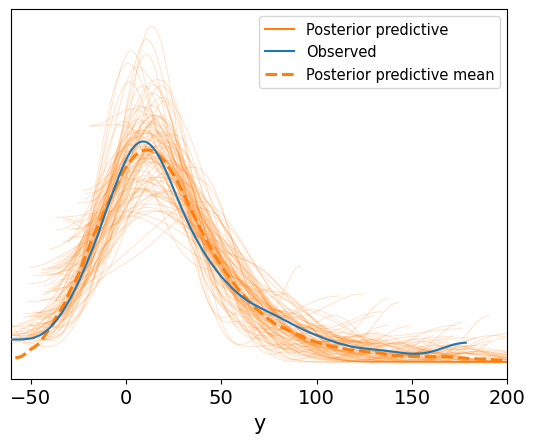

In [ ]:
pm.sample_posterior_predictive(idata_ff,model_ff, extend_inferencedata=True)
ax = az.plot_ppc(idata_ff, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(-60, 200)

The posterior predictive check is **excellent**. Both the peak and the tails are **mostly matched**. This tells me that my BART model is quite good. Now, let's plot **Change vs. MKT** since I believe MKT is the most important factor to change in stock price.

In [ ]:
posterior_mean = idata_ff.posterior["μ"]

μ_hdi = az.hdi(ary=idata_ff, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_ff, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


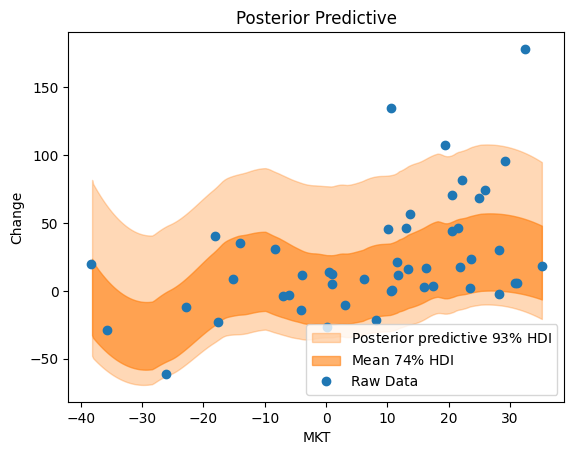

In [ ]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab first row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps, # changed
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(ff_stats['MKT'], ff_stats["Change"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="MKT",
    ylabel="Change",
);

Credit to Mr. Arredondo for helping me find the right code for this plot (changed variation in mean to the posterior predictive).

This plot looks quite good (it fits the data in a meaningful way without overfitting the later outliers). I also think it makes sense in reality, since bad stock market conditions (low MKT) generally mean stock prices will go down and as MKT increases, change fluctuates between positive and negative (hard to say whether a stock will go up or down even if market conditions are relatively good).

## Part IV: VI, PD, and ICE Plots

To see which factors the most, I will create a **variable importance (VI) plot**.

<Axes: ylabel='R²'>

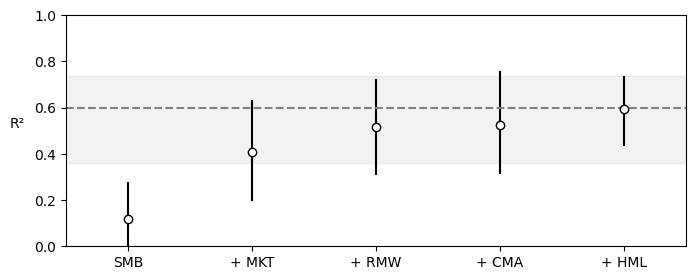

In [ ]:
vi_ff = pmb.compute_variable_importance(idata_ff, μ_, X)
pmb.plot_variable_importance(vi_ff)

It's obvious here that **MKT is the most important factor** out of the five, with HML and RMW coming in second and third respectively. CMA and SMB were  less useful than the other three factors, which is interesting since SMB was one of the first three factors introduced in 1992 and was considered extremely important. The final R^2 value came out to around **0.61** which is a lot lower than I expected, since these five factors often account for 90-95% of a stock portfolio's growth. However, it's not too unexpected since the Fama-French models typically are used for diversified portfolios, NOT individual stocks.

Now, let's create the partial dependence and independent conditional expectation plots to see the connections between these five factors.

array([<Axes: xlabel='MKT'>, <Axes: xlabel='SMB'>, <Axes: xlabel='HML'>,
       <Axes: xlabel='RMW'>, <Axes: xlabel='CMA'>], dtype=object)

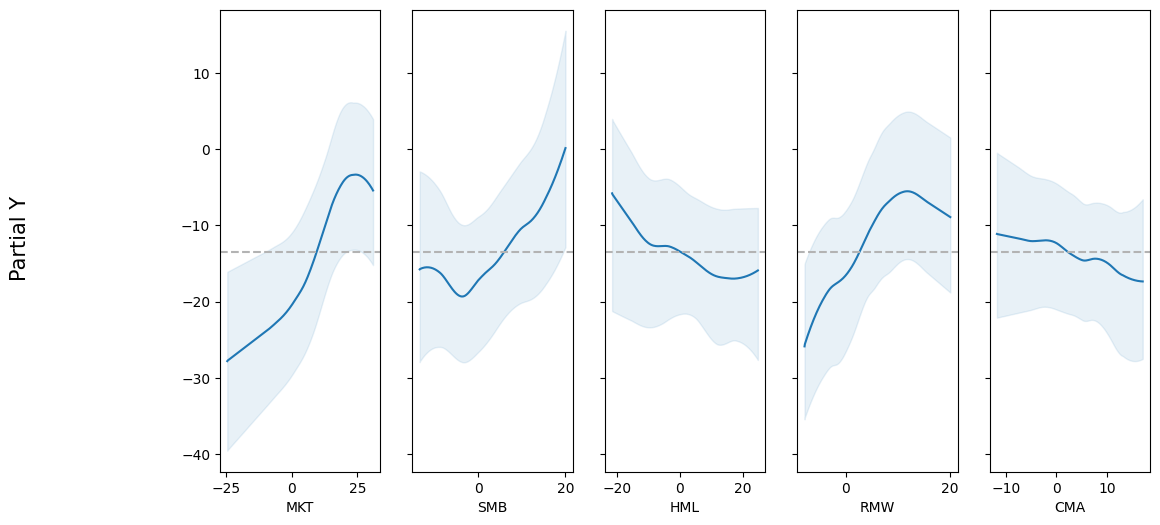

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='MKT'>, <Axes: xlabel='SMB'>, <Axes: xlabel='HML'>,
       <Axes: xlabel='RMW'>, <Axes: xlabel='CMA'>], dtype=object)

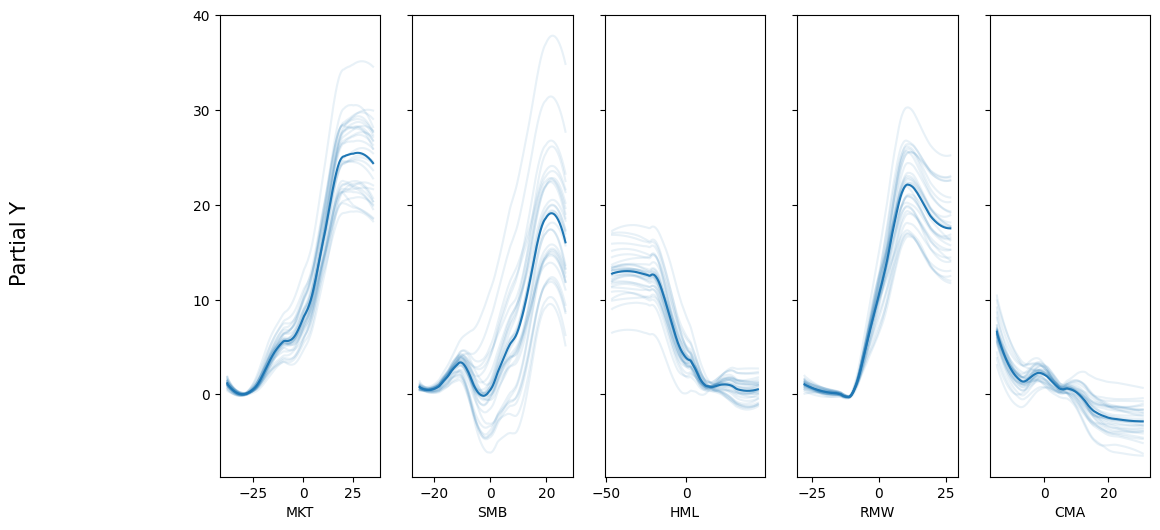

In [ ]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize = (12,6))

These plots reinforce our belief that MKT is the most important factor of the five. It has the steepest slope on the PDP, meaning that it makes the biggest difference in change. One interesting thing that I noticed was that the PDP seems to imply that as MKT gets really large, the stock price change actually goes down again, which is probably just a dataset size thing since again, FF5 is supposed to be used for large stock portfolios, not individual stocks. As for relationships between variables, MKT seems to have a bit of codependence at high values but quite independent at low values. The most dependent factor is SMB which has wildly varying curves at mid to high levels on the ICE plot.

However, there's one glaring feature of the PDP and VI that makes me worried about the model, which is CMA. The CMA VI implies that it is practically useless and the VI plot suggests that it could possibly even make the model *worse*. Let's make a model without CMA and see how it does.

## Part V: BART Model Without CMA

In [ ]:
Xd = ff_stats[["MKT", "SMB", "HML", "RMW"]] # d stands for dropped (CMA)
Yd = ff_stats["Change"].to_numpy()

In [ ]:
with pm.Model() as model_ffd:
    s = pm.HalfNormal('s', 10)
    μ_d = pmb.BART("μ_", Xd, Yd, m=50)
    μ = pm.Deterministic("μ", μ_d)
    y = pm.SkewStudentT("y", mu=μ, sigma=s, a = 6, b = 1, observed=Y)
    idata_ffd = pm.sample(compute_convergence_checks=False)

Output()

Output()

(-60.0, 200.0)

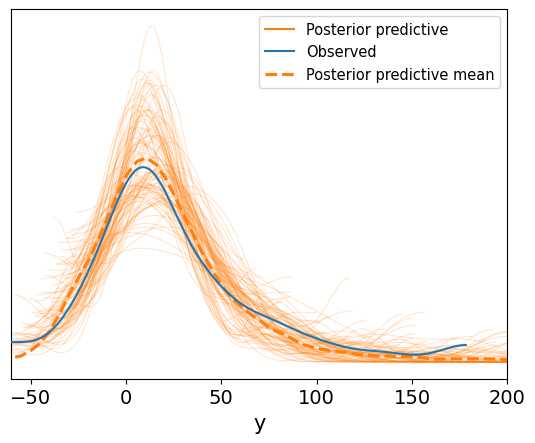

In [ ]:
pm.sample_posterior_predictive(idata_ffd, model_ffd, extend_inferencedata=True)
ax = az.plot_ppc(idata_ffd, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlim(-60, 200)

<Axes: ylabel='R²'>

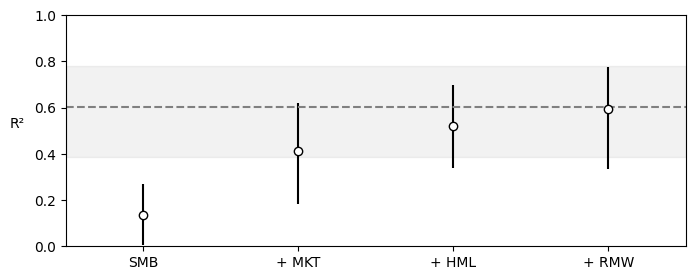

In [ ]:
vi_ffd = pmb.compute_variable_importance(idata_ffd, μ_d, Xd)
pmb.plot_variable_importance(vi_ffd)

array([<Axes: xlabel='MKT'>, <Axes: xlabel='SMB'>, <Axes: xlabel='HML'>,
       <Axes: xlabel='RMW'>], dtype=object)

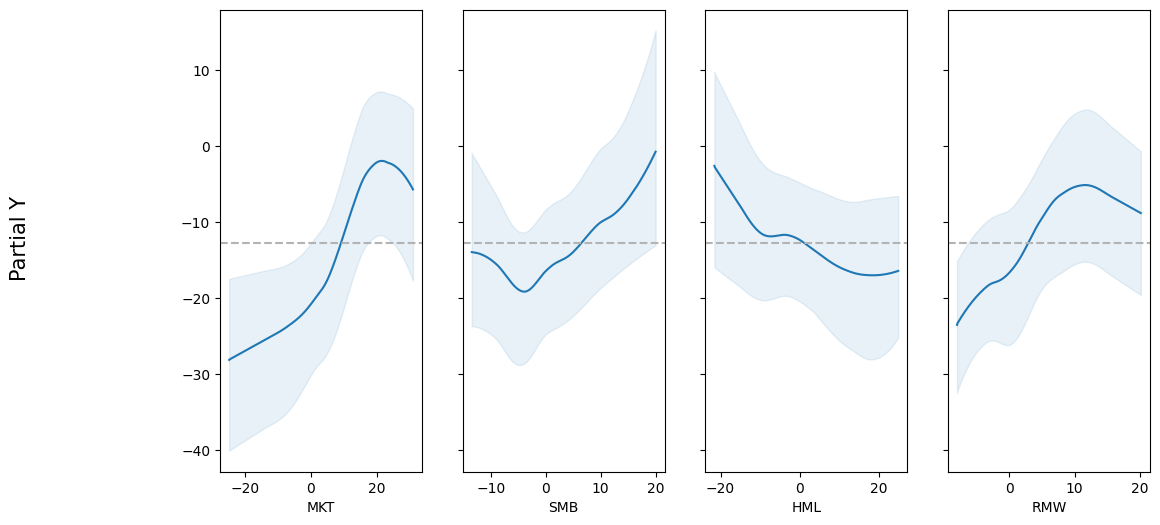

In [ ]:
pmb.plot_pdp(μ_d, Xd, Yd, grid=(1, 4), figsize = (12,6))

array([<Axes: xlabel='MKT'>, <Axes: xlabel='SMB'>, <Axes: xlabel='HML'>,
       <Axes: xlabel='RMW'>], dtype=object)

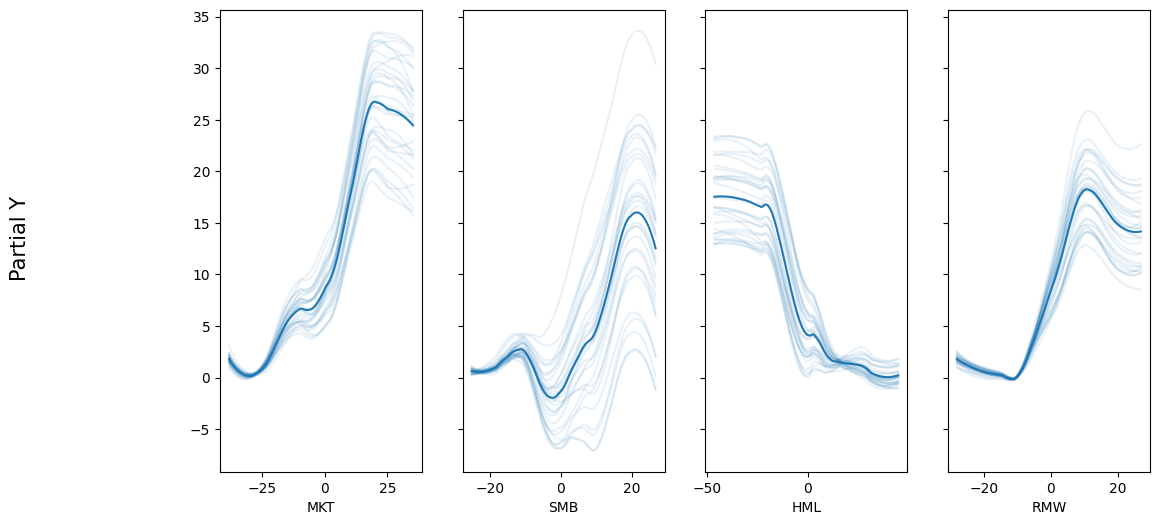

In [ ]:
pmb.plot_ice(μ_d, Xd, Yd, grid=(1, 4), figsize = (12,6))

Well, the results are basically identical, indicating CMA really wasn't important at all. The total R^2 is practically the same and MKT is still by far the most important factor. One potential difference is that the ICE plots look just a little wider, indicating more interaction between the four factors rather than the five factors, though this could just be a running inconsistency. Overall, my initial question was answered:

1. MKT is the most important factor and SMB comes in second. CMA is the least important factor in this situation.

2. There are significant interactions between the factors, especially with SMB and MKT at high values. This is visualized by my causal diagram, which illustrates the amount of interaction between the different factors.

In [ ]:
from ipywidgets import Widget

Widget.close_all()